# Numerical Exercises 02

## Exercise 02.2

- Compute the following 1D integral via Monte Carlo 
$$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$

1. sampling a uniform distribution in $[0,1]$
2. using importance sampling (i.e. sampling a non-uniform probability in $[0,1]$)

<span style="color:red">Show a picture of both your estimations of $I$</span> and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$</font>.

### Monte Carlo integration

If we want to compute the integral $$\int_a^b f(x) dx$$ the basic Monte carlo approach is to sample $N$ points $x_i$ uniformly in the interval $[a,b]$ and compute the average of the function values at these points:
$$I = \frac{b-a}{N} \sum_{i=1}^N f(x_i)$$

If we want to reduce the variance of the estimator, we can introduce importance sampling. The idea behind this technique is to sample points from a distribution that is more similar to the function we want to integrate. The integral is then computed as:
$$ I \simeq \frac{b-a}{N} \sum_{i=1}^N \frac{f(x_i)}{d(x_i)} d(x_i)$$
with $d(x_i)$ the probability density function of the distribution we are sampling from. The function $d(x)$ should be chosen such that it is non-zero in the interval $[a,b]$ and it is normalized.


### Solution

To evaluate the integral, i created the class `BA_integral` with two main methods:

```c++
void compute(double * data, string filename) override;
void compute_importance_sampling(double * rnd_data, string filename)
```

The first method computes the integral using the standard Monte Carlo method, while the second method uses importance sampling. Both methods evaluates the integral and the statistical error with the blocking average technique.

For the importance sampling i used the function $d(x) = 2-2x$ which is normalized in the interval $[0,1]$ and is similar to the function we want to integrate.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'

To have an idea of the two functions of interest:

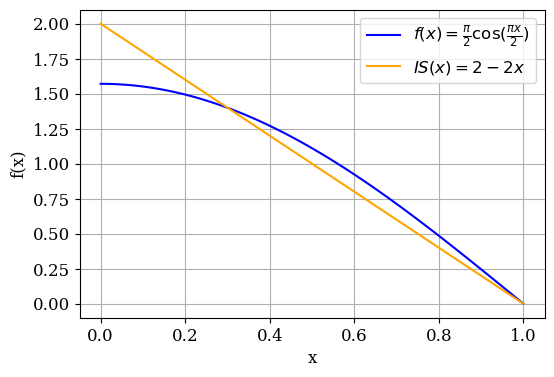

In [6]:
def f(x):
    return np.pi/2. * np.cos(np.pi*x/2.)

def IS_f(x):
    return 2. - 2*x

x = np.linspace(0, 1, 100)
plt.figure(figsize=(6, 4))
plt.plot(x, f(x), label=r'$f(x) = \frac{\pi}{2} \cos(\frac{\pi x}{2})$', color='blue')
plt.plot(x, IS_f(x), label=r'$IS(x) = 2 - 2x$', color='orange')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()
plt.legend()
plt.show()

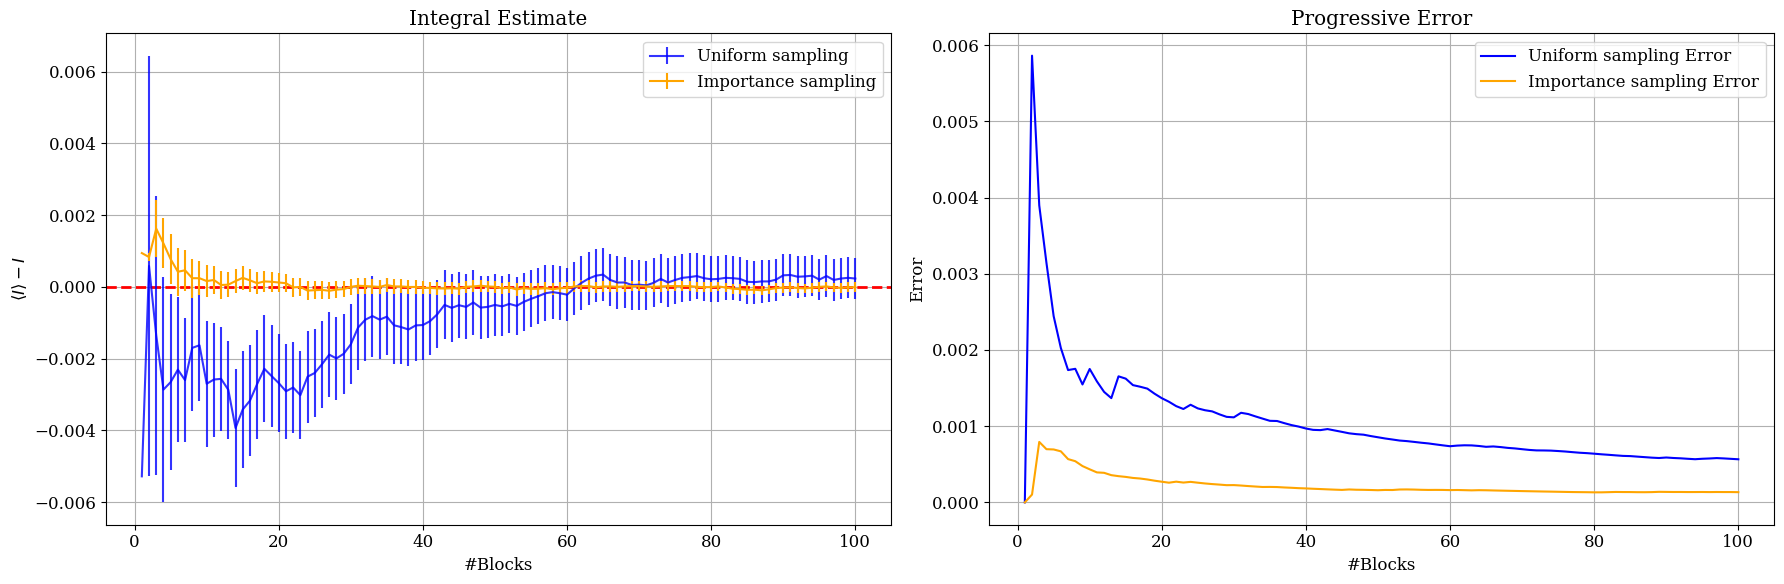

In [8]:
unif_data = pd.read_csv('data/integral_uniform_sampling.dat', sep = ' ')
importance_data = pd.read_csv('data/integral_importance_sampling.dat', sep = ' ')

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].axhline(0, color='red', lw=2., ls='--')
axs[0].errorbar(unif_data['#Blocks'], unif_data['Estimate']-1, yerr=unif_data['Error'], label='Uniform sampling', alpha =0.8, color = 'blue')
axs[0].errorbar(importance_data['#Blocks'], importance_data['Estimate']-1, yerr=importance_data['Error'], label='Importance sampling', alpha =1, color = 'orange')
axs[0].legend()
axs[0].set_xlabel('#Blocks')
axs[0].set_ylabel(r'$\langle I \rangle - I$')
axs[0].set_title('Integral Estimate')
axs[0].grid(True)

axs[1].plot(unif_data['#Blocks'], unif_data['Error'], label='Uniform sampling Error', color = 'blue')
axs[1].plot(importance_data['#Blocks'], importance_data['Error'], label='Importance sampling Error', color = 'orange')
axs[1].legend()
axs[1].set_xlabel('#Blocks')
axs[1].set_ylabel('Error')
axs[1].set_title('Progressive Error')
axs[1].grid(True)

plt.tight_layout()
plt.show()

From the plots above one can observe that both estimates converge to the theoretical value, however (as we expected) the calculation by importance sampling converges very quickly with far less error than the calculation with uniform distribution.

## Exercise 02.2

- <span style="color:red">3D Random Walks (RW) on a cubic lattice and in the continuum:</span> Repeat many times (e.g. say $10^4$) the simulation of a random walk in 3D always starting at the origin

1. on a cubic lattice with lattice constant $a=1$; at each discrete time the walker makes a forward or backward step of length equal to $a$ in one of the 3 principal directions of the lattice: $x$, $y$ or $z$

2. in the continuum; at each discrete time the walker makes a step of length equal to $a(=1)$ along a **random direction** obtained by sampling **uniformly** the solid angle: $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$

<span style="color:red">Show a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ for both RWs</span>, with their statistical uncertainties, as function of the step $i\in [0,10^2]$.





### Solution

To carry out the exercise, I implemented a class `RW`that simulates the random walk in 3D. For the discrete case the upgrade of the position is given by:

```c++
void RW::update_discrete(){
    int dir = int(rand_gen.Rannyu(0,3)); // select random direction
    pos[dir] += (rand_gen.Rannyu() < 0.5) ? 1 : -1; // move forward or backward
}
```

### Sampling uniformly the solid angle

For the continuous case we need to sample the solid angle uniformly, so the pdf is $p(\omega) = \frac{1}{4\pi}$. To move to spherical coordinates we exploit the conservation of probability $$p(\omega) d\omega = p(\theta, \phi) d\theta d\phi$$ where $d\omega = \sin(\theta) d\theta d\phi$ is the solid angle element. 

The marginal pdf for $\theta$ is given by:
$$p(\theta) = \int_0^{2\pi} p(\theta, \phi) d\phi = \frac{1}{4\pi} \int_0^{2\pi} \sin(\theta) d\phi = \frac{1}{2} \sin(\theta)$$ 
the conditional pdf for $\phi$ is given by:
$$p(\phi|\theta) = \frac{p(\theta, \phi)}{p(\theta)} = \frac{1}{2\pi}$$

To sample uniformly we evaluate the CDF for $p(\theta)$, $P(\theta) = \frac{1-\cos(\theta)}{2}$ and $P(\phi|\theta) = \frac{\phi}{2\pi}$. Inverting the CDF we obtain:
$$\theta = \arccos(1-2u)$$
$$\phi = 2\pi v$$
where $u$ and $v$ are two independent random number drawn uniformely from the interval $[0,1)$. 

The position is then updated as:
```c++
void RW::update_continuous(){
    double phi = rand_gen.Rannyu(0, 2*M_PI);
    double theta = acos(1-2.*rand_gen.Rannyu());
    pos[0] += sin(theta)*cos(phi);
    pos[1] += sin(theta)*sin(phi);
    pos[2] += cos(theta);
}
```


Here a plot of the uniformly sampled solid angle

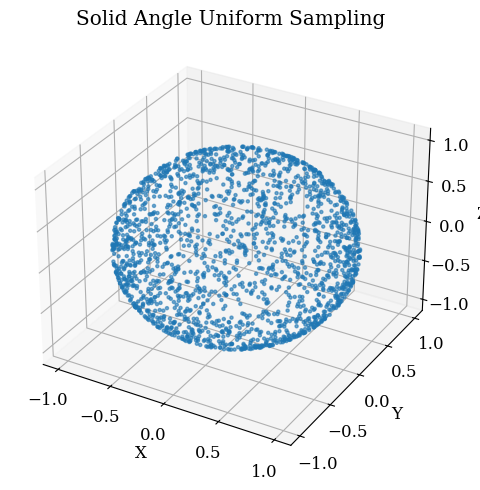

In [9]:
solid_data = pd.read_csv('data/solid_angle_sampling.dat', sep = ' ')
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(solid_data['x'], solid_data['y'], solid_data['z'], marker='.', alpha=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Solid Angle Uniform Sampling')
#plt.savefig('data/solid_angle_sampling.png', dpi=300)
plt.show()

---

To evaluate $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ i divided the total number of trajectories $M = 10^4$ in $N = 100$ blocks. Then, by iterating over all the blocks, I computed the average distance from the origin at each step of the trajectory using the data blocking method. For each trajectory, the walker was reset to the initial position.

I repeated the entire procedure for both the discrete and continuous random walk cases, updating the position as described above.

```c++
for(int i=0; i<n_blocks;i++){
    double * dist = new double[n_steps]();
    for(int j=0; j<n_trajec/n_blocks; j++){  // loop on trajectories in each block
        walker.restart();
        for(int k=0; k<n_steps; k++){ // single trajectory
            walker.update_discrete(); // or walker.update_continuous();
            dist[k] += (walker.get_x()*walker.get_x() + walker.get_y()*walker.get_y() + walker.get_z()*walker.get_z())/(n_trajec/n_blocks); // evaluate the mean at the k-th step
        } 
    }

    for(int k=0; k<n_steps; k++){ // evaluate at each step the cumulative sum
        cum_sum[k] += sqrt(dist[k]); 
        cum_sum2[k] += dist[k];
    }
}
```

In [10]:
discrete_rw = pd.read_csv('data/3d_discrete_random_walk.dat', sep=' ')
cont_rw = pd.read_csv('data/3d_continuous_random_walk.dat', sep=' ')

In [11]:
def sqrt_fit(n, k):
    return k * np.sqrt(n)

# discrete rw fit
n_steps_discrete = discrete_rw['#step']
r_values_discrete = discrete_rw['r']
popt_discrete, pcov_discrete = curve_fit(sqrt_fit, n_steps_discrete, r_values_discrete)
k_fit_discrete = popt_discrete[0]
fit_values_discrete = sqrt_fit(n_steps_discrete, k_fit_discrete)

# continuous rw fit
n_steps_cont = cont_rw['#step']
r_values_cont = cont_rw['r']
popt_cont, pcov_cont = curve_fit(sqrt_fit, n_steps_cont, r_values_cont)
k_fit_cont = popt_cont[0]
fit_values_cont = sqrt_fit(n_steps_cont, k_fit_cont)


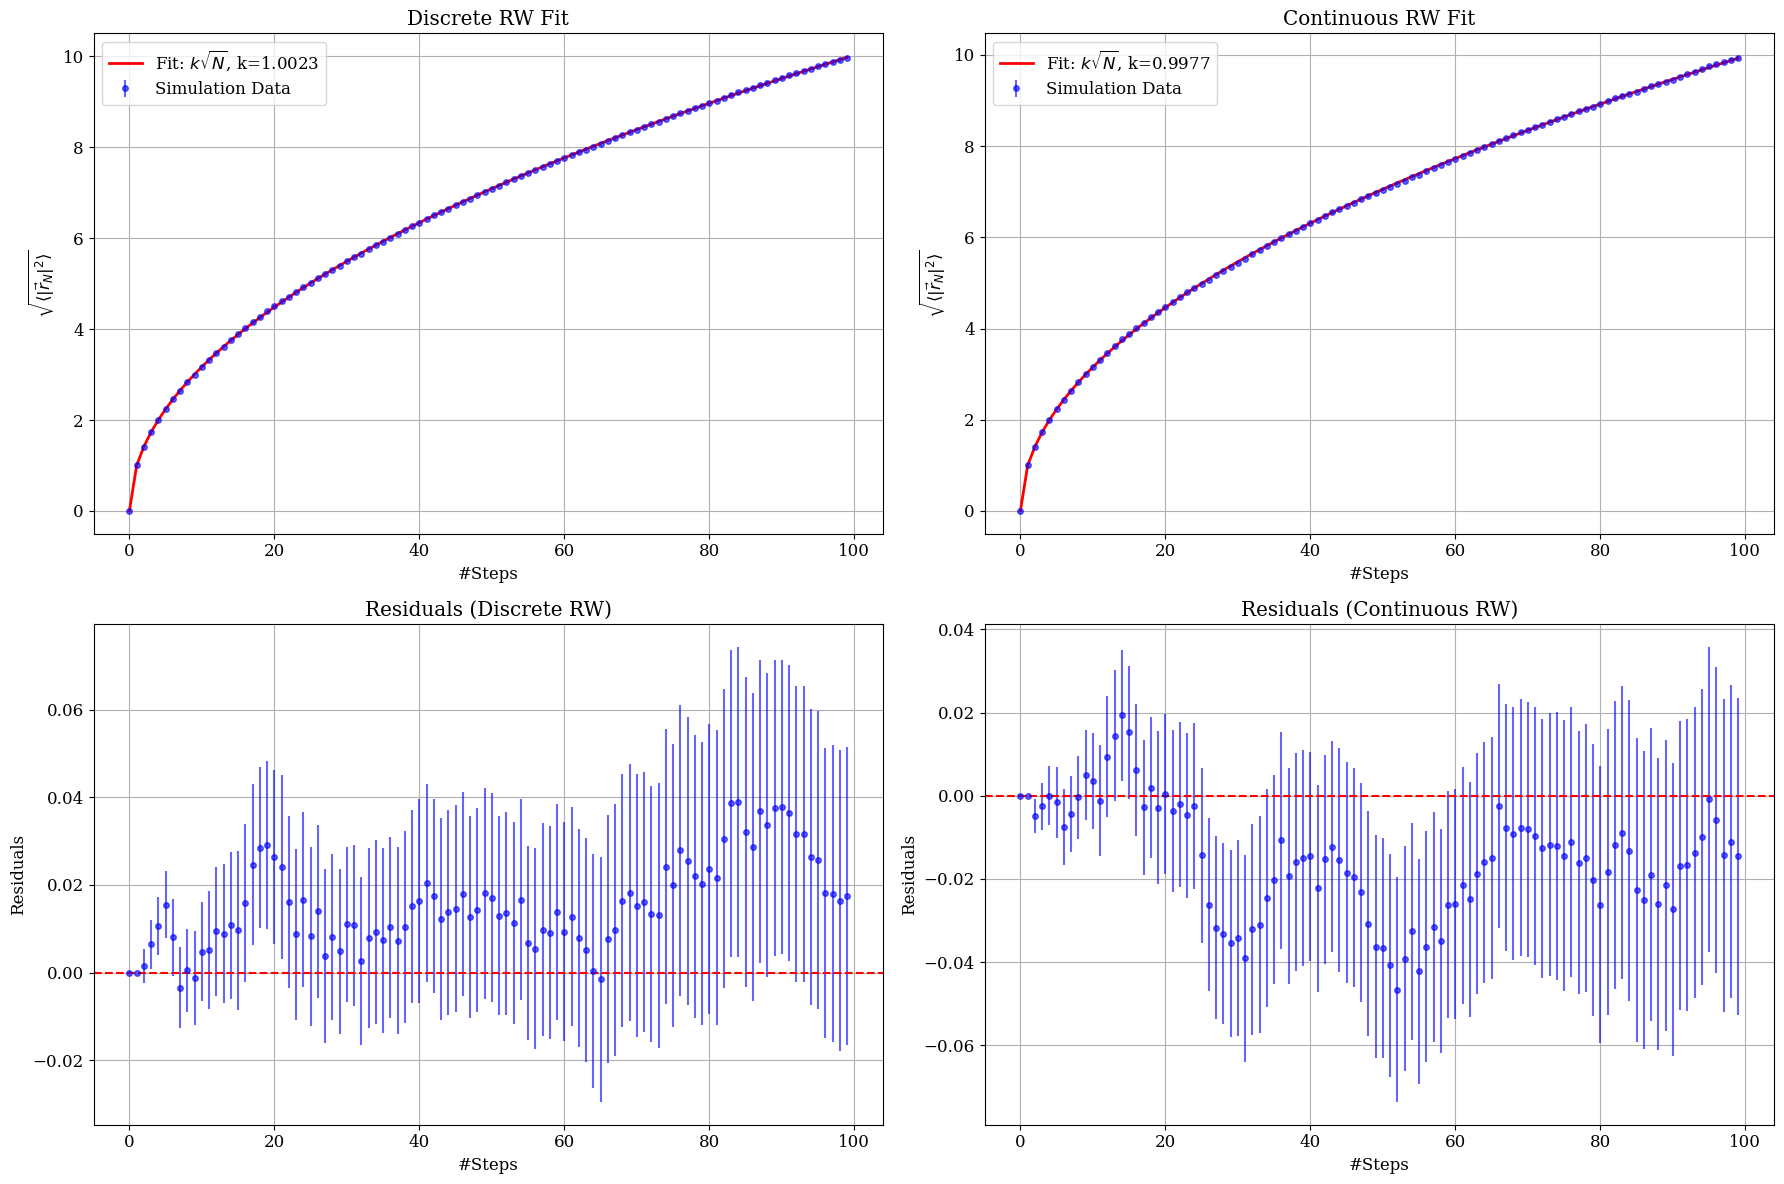

In [12]:

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

axs[0, 0].errorbar(n_steps_discrete, r_values_discrete, yerr=discrete_rw['error'], fmt='o', markersize=4, label='Simulation Data', color='blue', alpha=0.6)
axs[0, 0].plot(n_steps_discrete, fit_values_discrete, label=f'Fit: $k\\sqrt{{N}}$, k={k_fit_discrete:.4f}', color='red', linewidth=2)
axs[0, 0].set_xlabel('#Steps')
axs[0, 0].set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle}$')
axs[0, 0].set_title('Discrete RW Fit')
axs[0, 0].legend()
axs[0, 0].grid(True)

residuals_discrete = r_values_discrete - 1. * np.sqrt(n_steps_discrete)
axs[1, 0].errorbar(n_steps_discrete, residuals_discrete, yerr=discrete_rw['error'], fmt='o', markersize=4, label='Residuals', color='blue', alpha=0.6)
axs[1, 0].axhline(0, color='red', linestyle='--', linewidth=1.5)
axs[1, 0].set_xlabel('#Steps')
axs[1, 0].set_ylabel('Residuals')
axs[1, 0].set_title('Residuals (Discrete RW)')
axs[1, 0].grid(True)

axs[0, 1].errorbar(n_steps_cont, r_values_cont, yerr=cont_rw['error'], fmt='o', markersize=4, label='Simulation Data', color='blue', alpha=0.6)
axs[0, 1].plot(n_steps_cont, fit_values_cont, label=f'Fit: $k\\sqrt{{N}}$, k={k_fit_cont:.4f}', color='red', linewidth=2)
axs[0, 1].set_xlabel('#Steps')
axs[0, 1].set_ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle}$')
axs[0, 1].set_title('Continuous RW Fit')
axs[0, 1].legend()
axs[0, 1].grid(True)

residuals_cont = r_values_cont - 1. * np.sqrt(n_steps_cont)
axs[1, 1].errorbar(n_steps_cont, residuals_cont, yerr=cont_rw['error'], fmt='o', markersize=4, label='Residuals', color='blue', alpha=0.6)
axs[1, 1].axhline(0, color='red', linestyle='--', linewidth=1.5)
axs[1, 1].set_xlabel('#Steps')
axs[1, 1].set_ylabel('Residuals')
axs[1, 1].set_title('Residuals (Continuous RW)')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

From these plots it is evident that there is a good agreement between the simulation data and the theoretical diffusive prediction with $k \simeq 1$.

The fluctuations from the true value are within (for most steps) the statistical error, at most  $2\sigma$.